In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import time
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
#from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
#from helper_functions.invertible_neural_network_positive import InvertibleNetworkSurrogate

from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score#,mean_absolute_percentage_error

2023-01-13 09:53:46.462841: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2023-01-13 09:53:46.463920: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-13 09:53:46.464154: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [2]:
class RSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self):
        super().__init__(name='r2')

    def call(self, y_true, y_pred):
        mean_true = tf.math.reduce_mean(y_true, axis=0)

        total_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, mean_true),
                                                  axis=0)
        
        residual_sum_of_squares = tf.math.reduce_sum(tf.math.squared_difference(y_true, y_pred),
                                                     axis=0)
        r2 = 1. - residual_sum_of_squares / total_sum_of_squares

        return r2

In [3]:
class AdjustedRSquaredSeparated(tf.keras.losses.Loss):
    '''
    Calculates the adjusted R^2 value for each predicted quantity separately.

    For more details, see:
    https://www.analyticsvidhya.com/blog/2020/07/difference-between-r-squared-and-adjusted-r-squared/
    '''
    def __init__(self, batch_size, number_of_input):
        '''
        Parameters
        ==========
        batch_size: int
            Number of samples in a batch,
            i. e. number of rows of a batch of the X matrix.
        number_of_input: int
            Number of independent variables (=columns) in the problem,
            i. e. number of columns of the X matrix.
        '''
        super().__init__(name='adjusted_r2')
        self._n = batch_size
        self._n_in = number_of_input

    def call(self, y_true, y_pred):
        r2 = RSquaredSeparated().call(y_true, y_pred)

        adjusted_r2 = 1. - (1. - r2) * (self._n - 1.) / (self._n - self._n_in - 1.)

        return adjusted_r2

    @classmethod
    def from_config(cls, config):
        return AdjustedRSquaredSeparated(config['n'], config['n_in'])

    def get_config(self):
        return {
            'n': self._n,
            'n_in': self._n_in,
        }

In [4]:
# wMAPE

def wmape(actual, pred):
    wMAPE = np.sum(np.abs(actual-pred))/np.sum(np.abs(actual))*100
    return wMAPE

In [5]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

### Import test data

In [6]:
test_datafile = '/data/project/general/aerosolretriev/aerosol_data/dataset_12_2022/preprocessed_new/data_all_test_iv1_small.h5'

In [7]:
dvar_test = pd.read_hdf(test_datafile, key = 'dvar')
qoi_test = pd.read_hdf(test_datafile, key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

qoi_columns = qoi_test.columns
dvar_columns = dvar_test.columns

In [8]:
# Process F11 and PPF for the plots --> np.exp(F11)

F11_list = [x for x in qoi_test.columns if 'F11' in x]
PPF_list = [x for x in qoi_test.columns if 'PPF' in x]

qoi_test_plot = qoi_test.copy()
qoi_test_plot[F11_list] = np.exp(qoi_test_plot[F11_list])
qoi_test_plot[PPF_list] = (qoi_test_plot[PPF_list])

In [9]:
# Process the state parameters to get back "normal" values --> np.exp(V), np.axp(R), np.exp(GSD)+1, np.exp(n)+1.33, np.exp(k)

dvar_test_plot = dvar_test.copy()
dvar_test_plot['Vtot'] = np.exp(dvar_test['Vtot'])
dvar_test_plot['RmedianV'] = np.exp(dvar_test['RmedianV'])
dvar_test_plot['GSD'] = np.exp(dvar_test['GSD'])+1
dvar_test_plot['n'] = np.exp(dvar_test['n'])+1.33
dvar_test_plot['k'] = np.exp(dvar_test['k'])

### Load the model to test

In [10]:
model_name = 'invertible_model'
val_model_name = 'forward_model'

# Model directory
directory = '/data/project/general/aerosolretriev/aerosol_results_december_2022/results_Romana/results_12_12_2022/invertible_models_iv1_small'
model_dir = directory + '/models'

# Plot directory (subdirectory of the model)
test_directory = '/data/project/general/aerosolretriev/aerosol_results_january_2023/results_Barbara/test_to_be_cancelled'
plot_dir = test_directory +'/plots/model'
#plot_dir = model_dir +'/plots/validation_data'

if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

In [11]:
custom_objects = {'AdjustedRSquared':AdjustedRSquared}

kwargs = {'custom_objects':custom_objects, 'compile': False}

surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

#### Forward prediction

In [12]:
start = time.time()
qoi_pred_fw = surr.predict(dvar_test.values)
end = time.time()
dt = (end-start)#/len(dvar_test)

qoi_pred_fw = pd.DataFrame(data=qoi_pred_fw, columns=qoi_columns)


print('Time for the forward prediction: %i s' %dt)

2023-01-13 09:53:51.137707: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-01-13 09:53:51.138337: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2100000000 Hz


Time for the forward prediction: 4 s


In [13]:
# Process the data for the plots --> np.exp(F11)

F11_list = [x for x in qoi_pred_fw.columns if 'F11' in x]
PPF_list = [x for x in qoi_pred_fw.columns if 'PPF' in x]

qoi_pred_fw_plot = qoi_pred_fw.copy()
qoi_pred_fw_plot[F11_list] = np.exp(qoi_pred_fw_plot[F11_list])
qoi_pred_fw_plot[PPF_list] = (qoi_pred_fw_plot[PPF_list])

#### Inverse prediction

In [14]:
start = time.time()
dvar_pred_iv_original = surr.sample_n_tries(qoi_test.values, batch_size = 8, n_tries = 1)
end = time.time()
dt = (end-start)#/len(dvar_test)

dvar_pred_iv = pd.DataFrame(data = dvar_pred_iv_original, columns = dvar_test.columns)

print('Time for the inverse prediction: %i s' %dt)

Time for the inverse prediction: 23 s


In [15]:
# Process the data to get back "normal" values --> np.exp(V), np.axp(R), np.exp(GSD)+1, np.exp(n)+1.33, np.exp(k)

dvar_pred_iv_plot = dvar_pred_iv.copy()
dvar_pred_iv_plot['Vtot'] = np.exp(dvar_pred_iv_plot['Vtot'])
dvar_pred_iv_plot['RmedianV'] = np.exp(dvar_pred_iv_plot['RmedianV'])
dvar_pred_iv_plot['GSD'] = np.exp(dvar_pred_iv_plot['GSD'])+1
dvar_pred_iv_plot['n'] = np.exp(dvar_pred_iv_plot['n'])+1.33
dvar_pred_iv_plot['k'] = np.exp(dvar_pred_iv_plot['k'])

### Metrics forward step

In [16]:
qoi_test_copy = qoi_test_plot.copy()
qoi_pred_fw_copy  = qoi_pred_fw_plot.copy()

#### 1. R2 - forward step

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$

In [17]:
# Define which metric to use
metric_fw = RSquaredSeparated() # separated means that it is calculated for each variable

r2_fw = metric_fw.call(qoi_test_copy.values, qoi_pred_fw_copy.values).numpy()
r2_fw = pd.Series(data=r2_fw, index=qoi_columns)
r2_fw = np.round(r2_fw, decimals=2)
r2_fw = pd.DataFrame(r2_fw).T

print('Forward model: R2_min = %.2f ; R2_max = %.2f ; R2_mean = %.2f '
      % (r2_fw.mean(axis=1), min(r2_fw.min()), max(r2_fw.max())))

Forward model: R2_min = 0.87 ; R2_max = -21.00 ; R2_mean = 0.99 


In [18]:
# List the 10 points with the lowest R2
r2_fw.sort_values(by=r2_fw.index[0], axis=1, ascending=True).iloc[:, :10]

F11_124  F11_36  F11_82  PPF_170  F11_46  F11_16  PPF_169  F11_55  F11_41  \
0    -21.0     0.1    0.34     0.68    0.69    0.69      0.7    0.73    0.75   

   PPF_168  
0     0.76

#### 2. Adjusted R2 - forward step

adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$

In [19]:
# Define which metric to use
metric2_fw = AdjustedRSquaredSeparated(qoi_test.shape[0], qoi_test.shape[1])

r2_adj_fw = metric2_fw.call(qoi_test_copy.values, qoi_pred_fw_copy.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=qoi_columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T

print('Forward model: R2adj_min = %.2f  ;  R2adj_max = %.2f  ;  R2adj_mean = %.2f '
      % (r2_adj_fw.mean(axis=1), min(r2_adj_fw.min()), max(r2_adj_fw.max())))

Forward model: R2adj_min = 0.87  ;  R2adj_max = -21.34  ;  R2adj_mean = 0.99 


In [20]:
# List the 10 points with the lowest adjR2
r2_adj_fw.sort_values(by=r2_adj_fw.index[0], axis=1, ascending=True).iloc[:, :10]

F11_124  F11_36  F11_82  PPF_170  F11_46  F11_16  PPF_169  F11_55  F11_41  \
0   -21.34    0.08    0.33     0.67    0.68    0.69      0.7    0.72    0.74   

   PPF_168  
0     0.75

#### 3. Absolute error - forward step

absolute_error = $|y_{true}-y_{pred}|$

In [21]:
abs_error_fw = np.abs(qoi_test_copy - qoi_pred_fw_copy)

In [22]:
abs_error_table_fw =  np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [23]:
abs_error_table_fw.sort_values(by=abs_error_table_fw.index[3], axis=1, ascending=False).iloc[:, :10]

F11_10   F11_12   F11_11   F11_13   F11_14   F11_16   F11_17   F11_15  \
50%     8.69     7.07     6.35     5.17     3.25     3.02     2.33     2.99   
75%    79.91    64.36    57.16    49.45    36.17    29.55    23.63    29.16   
90%   394.59   304.71   281.42   256.51   213.87   176.00   152.89   158.45   
95%   855.60   633.04   606.64   552.69   456.05   400.88   353.71   343.69   
99%  2756.99  2138.15  1857.59  1719.17  1322.20  1439.78  1255.95  1116.30   

      F11_20  F11_19  
50%     1.87    2.01  
75%    19.56   20.33  
90%   123.92  122.52  
95%   301.17  277.26  
99%  1010.44  959.22

In [24]:
abs_error_table_fw_F11 = abs_error_table_fw[F11_list]
print('Absolute error F11:')
print(abs_error_table_fw_F11.max(axis = 1))
print('\n')

abs_error_table_fw_PPF = abs_error_table_fw[PPF_list]
print('Absolute error PPF:')
print(abs_error_table_fw_PPF.max(axis = 1))
print('\n')


Absolute error F11:
50%       8.69
75%      79.91
90%     394.59
95%     855.60
99%    2756.99
dtype: float64


Absolute error PPF:
50%    0.01
75%    0.03
90%    0.04
95%    0.06
99%    0.09
dtype: float64




#### 4. Relative error - forward step

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

***be careful, if $y_{true}$ is very small***


In [25]:
rel_error_fw = abs_error_fw / (qoi_test_copy) * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=qoi_columns).abs()

In [26]:
rel_error_table_fw =  np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [27]:
rel_error_table_fw.sort_values(by=rel_error_table_fw.index[3], axis=1, ascending=False).iloc[:, :10]

PPF_10  F11_164  F11_144  PPF_165  PPF_12  PPF_11  PPF_14  PPF_168  \
50%    4.72    12.14    13.47     8.19    3.07    3.60    3.50     8.35   
75%   14.84    26.31    24.98    20.32    7.78    8.73    8.68    17.77   
90%   48.02    46.92    42.96    41.82   23.57   24.39   24.25    32.28   
95%  123.06    62.25    61.83    61.45   53.16   53.15   50.95    48.23   
99%  635.77   102.99   124.71   148.99  266.95  281.88  239.93   150.08   

     PPF_170  F11_12  
50%     7.62    8.41  
75%    16.85   19.15  
90%    33.33   35.02  
95%    48.19   46.46  
99%   140.97   75.89

In [28]:
rel_error_table_fw_F11 = rel_error_table_fw[F11_list]
print('Relative error F11:')
print(rel_error_table_fw_F11.max(axis=1))
print('\n')

rel_error_table_fw_PPF = rel_error_table_fw[PPF_list]
print('Relative error PPF:')
print(rel_error_table_fw_PPF.max(axis=1))

Relative error F11:
50%     13.47
75%     26.31
90%     46.92
95%     62.25
99%    124.71
dtype: float64


Relative error PPF:
50%      9.55
75%     20.32
90%     48.02
95%    123.06
99%    635.77
dtype: float64


#### 5. wMAPE - forward step

In [29]:
wMAPE_fw = wmape(qoi_test_copy, qoi_pred_fw_copy)
wMAPE_fw = pd.DataFrame(wMAPE_fw).T

In [30]:
wMAPE_fw.sort_values(by=wMAPE_fw.index[0], axis=1, ascending=False).iloc[:, :10]

F11_124    F11_144    F11_164    PPF_170    PPF_168    PPF_169    PPF_165  \
0  25.20308  23.031082  19.929928  16.211132  16.126761  15.507611  15.442028   

      F11_82    F11_105    F11_141  
0  15.438185  14.154603  13.556591

In [31]:
print('Mean wMAP value for F11: %.3f' % wMAPE_fw[F11_list].mean().mean())

Mean wMAP value for F11: 9.180


In [32]:
print('Mean wMAP value for PPF: %.3f' % wMAPE_fw[PPF_list].mean().mean())

Mean wMAP value for PPF: 5.252


### Metrics inverse step

In [33]:
dvar_test_copy = dvar_test.copy()
dvar_pred_iv_copy = dvar_pred_iv.copy()

#### 1. R2 - inverse step

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$

In [34]:
# Define which metric to use
metric_iv = RSquaredSeparated() # separated means that it is calculated for each variable

r2_iv = metric_iv.call(dvar_test_copy.values, dvar_pred_iv_copy.values).numpy()
r2_iv = pd.Series(data=r2_iv, index=dvar_columns)
r2_iv = np.round(r2_iv, decimals=2)
r2_iv = pd.DataFrame(r2_iv).T

print('Inverse model: R2_min = %.2f ; R2_max = %.2f ; R2_mean = %.2f '
      % (r2_iv.mean(axis=1), min(r2_iv.min()), max(r2_iv.max())))

Inverse model: R2_min = 0.97 ; R2_max = 0.92 ; R2_mean = 1.00 


In [35]:
# List the 10 points with the lowest R2
r2_iv.sort_values(by=r2_iv.index[0], axis=1, ascending=True)

n   GSD     k  RmedianV  Vtot
0  0.92  0.97  0.97      0.99   1.0

#### 2. Adjusted R2 - inverse step

adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$

In [36]:
# Define which metric to use
metric2_iv = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])

r2_adj_iv = metric2_iv.call(dvar_test_copy.values, dvar_pred_iv_copy.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=dvar_columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T

print('Inverse model: R2adj_min = %.2f  ;  R2adj_max = %.2f  ;  R2adj_mean = %.2f '
      % (r2_adj_iv.mean(axis=1), min(r2_adj_iv.min()), max(r2_adj_iv.max())))

Inverse model: R2adj_min = 0.97  ;  R2adj_max = 0.92  ;  R2adj_mean = 1.00 


In [37]:
# List the 10 points with the lowest adjR2
r2_adj_iv.sort_values(by=r2_adj_iv.index[0], axis=1, ascending=True).iloc[:, :10]

n   GSD     k  RmedianV  Vtot
0  0.92  0.97  0.97      0.99   1.0

#### 3. Absolute error - inverse step

absolute_error = $|y_{true}-y_{pred}|$

In [38]:
abs_error_iv = np.abs(dvar_test_copy - dvar_pred_iv_copy)

In [39]:
abs_error_table_iv =  np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [40]:
abs_error_table_iv.sort_values(by=abs_error_table_iv.index[3], axis=1, ascending=False)

n     k   GSD  Vtot  RmedianV
50%  0.07  0.06  0.05  0.05      0.04
75%  0.14  0.11  0.10  0.10      0.09
90%  0.25  0.19  0.17  0.16      0.15
95%  0.38  0.28  0.24  0.21      0.20
99%  1.16  0.62  0.52  0.35      0.30

In [41]:
print('Inverse model: mean abs. error \n')
print(abs_error_iv.mean())

Inverse model: mean abs. error 

Vtot        0.073912
RmedianV    0.066637
GSD         0.081003
n           0.132121
k           0.096924
dtype: float64


In [42]:
print('Inverse model: max abs. error \n')
print(abs_error_iv.max())

Inverse model: max abs. error 

Vtot        2.215484
RmedianV    1.694352
GSD         2.675358
n           6.610401
k           5.034215
dtype: float64


#### 4. Relative error - inverse step

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

***be careful, if $y_{true}$ is very small***


In [43]:
rel_error_iv = abs_error_iv / (dvar_test_copy) * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=dvar_columns).abs()

In [44]:
rel_error_table_iv =  np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)

In [45]:
rel_error_table_iv.sort_values(by=rel_error_table_iv.index[3], axis=1, ascending=False)

n     GSD       k   Vtot  RmedianV
50%   17.65   11.80   13.02   1.48      0.69
75%   39.35   28.08   27.79   3.00      1.40
90%   96.65   74.49   66.26   7.37      2.41
95%  184.01  152.69  130.14  16.05      3.10
99%  813.53  766.09  678.24  84.38      4.74

In [46]:
print('Inverse model: mean rel error in % \n')
print(rel_error_iv.mean())

Inverse model: mean rel error in % 

Vtot         15.585509
RmedianV      1.020364
GSD          87.419538
n           220.555023
k           101.778363
dtype: float64


In [47]:
print('Inverse model: max rel error in % \n')
print(rel_error_iv.max())

Inverse model: max rel error in % 

Vtot        1.560876e+05
RmedianV    2.027035e+01
GSD         1.891087e+05
n           2.258095e+06
k           2.588759e+05
dtype: float64


#### 5. wMAPE - inverse step

In [48]:
wMAPE_iv = wmape(dvar_test_copy, dvar_pred_iv_copy)
wMAPE_iv = pd.DataFrame(wMAPE_iv).T

In [49]:
wMAPE_iv.sort_values(by=wMAPE_iv.index[0], axis=1, ascending=False)

n          k        GSD      Vtot  RmedianV
0  18.627708  13.867716  13.185933  1.725603    1.0193

In [50]:
print('Mean wMAP value for F11: %.3f' % wMAPE_fw[F11_list].mean().mean())

Mean wMAP value for F11: 9.180


In [51]:
print('Mean wMAP value for PPF: %.3f' % wMAPE_fw[PPF_list].mean().mean())

Mean wMAP value for PPF: 5.252


### Performance summary

In [52]:
performance = pd.DataFrame(columns = ['F11','PPF','Vtot','RmedianV','GSD','n','k'])

performance.loc['R2']= [r2_fw[F11_list].mean(axis=1)[0],
                        r2_fw[PPF_list].mean(axis=1)[0],
                        r2_iv['Vtot'][0],
                        r2_iv['RmedianV'][0],
                        r2_iv['GSD'][0],
                        r2_iv['n'][0],
                        r2_iv['k'][0]
                       ]

performance.loc['R2adj']= [r2_adj_fw[F11_list].mean(axis=1)[0],
                            r2_adj_fw[PPF_list].mean(axis=1)[0],
                            r2_adj_iv['Vtot'][0],
                            r2_adj_iv['RmedianV'][0],
                            r2_adj_iv['GSD'][0],
                            r2_adj_iv['n'][0],
                            r2_adj_iv['k'][0]
                           ]

performance.loc['max_abs_err_95%']= [abs_error_table_fw_F11.max(axis = 1)['95%'],
                                     abs_error_table_fw_PPF.max(axis = 1)['95%'],
                                     abs_error_table_iv.loc['95%']['Vtot'],
                                     abs_error_table_iv.loc['95%']['RmedianV'],
                                     abs_error_table_iv.loc['95%']['GSD'],
                                     abs_error_table_iv.loc['95%']['n'],
                                     abs_error_table_iv.loc['95%']['k']
                                    ]

performance.loc['max_rel_err_95%']= [rel_error_table_fw_F11.max(axis = 1)['95%'],
                                     rel_error_table_fw_PPF.max(axis = 1)['95%'],
                                     rel_error_table_iv.loc['95%']['Vtot'],
                                     rel_error_table_iv.loc['95%']['RmedianV'],
                                     rel_error_table_iv.loc['95%']['GSD'],
                                     rel_error_table_iv.loc['95%']['n'],
                                     rel_error_table_iv.loc['95%']['k']
                                    ]

performance.loc['wMAPE']= [wMAPE_fw[F11_list].mean().mean(),
                           wMAPE_fw[PPF_list].mean().mean(),
                           wMAPE_iv['Vtot'][0],
                           wMAPE_iv['RmedianV'][0],
                           wMAPE_iv['GSD'][0],
                           wMAPE_iv['n'][0],
                           wMAPE_iv['k'][0]
                          ]

#performance.loc['rel_err_max_95%']= [rel_error_table_fw_F11.max(axis = 1)['95%'],rel_error_table_fw_PPF.max(axis = 1)['95%'],rel_error_table_iv.loc['95%'].values[0],rel_error_table_iv.loc['95%'].values[1],rel_error_table_iv.loc['95%'].values[2],rel_error_table_iv.loc['95%'].values[3],rel_error_table_iv.loc['95%'].values[4]]
#performance.loc['wmape']= [,,,,,,]



### Plot for validation vs predicted values

In [53]:
index_list = [100, 1000, 10000]

In [54]:
angles1 = np.arange(10,86)
angles2 = np.arange(95,171)
angles_plot = np.concatenate([angles1, angles2])

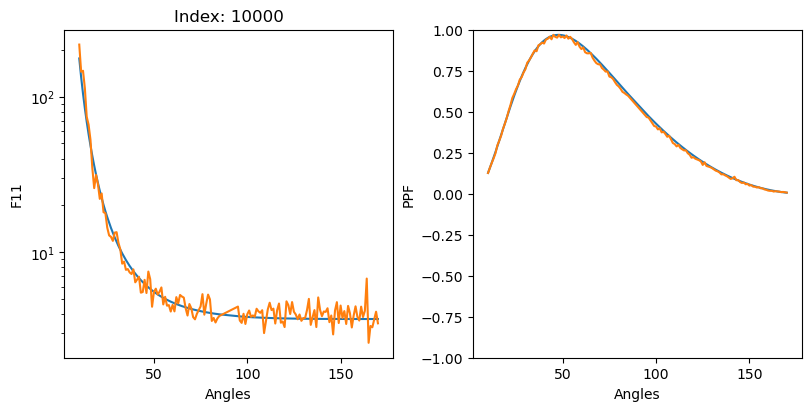

In [55]:
for idx in index_list:
    fig, axs = plt.subplots(ncols=2, figsize=(8, 4), constrained_layout=True)

    axs[0].set_title('Index: %i' %idx)
    axs[0].plot(angles_plot, qoi_test_plot[F11_list].iloc[idx], c='C0')
    axs[0].plot(angles_plot, qoi_pred_fw_plot[F11_list].iloc[idx], c='C1')
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Angles')
    axs[0].set_ylabel('F11')
    
    axs[1].plot(angles_plot, qoi_test_plot[PPF_list].iloc[idx], c='C0')
    axs[1].plot(angles_plot, qoi_pred_fw_plot[PPF_list].iloc[idx], c='C1')
    axs[1].set_ylim(-1, 1)
    axs[1].set_xlabel('Angles')
    axs[1].set_ylabel('PPF')
   
    fig.savefig(f'{plot_dir}/PF_PPF_pred_index_'+str(idx)+'.jpg')

In [56]:
plt.figure()

plt.plot(qoi_test_copy.loc[index][F11_list],'b')
plt.plot(qoi_pred_fw_copy.loc[index][F11_list],'r')
plt.yscale('log')

NameError: name 'index' is not defined

<Figure size 640x480 with 0 Axes>